# Linear PV Estimator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
from oedisi.componentframework import wiring_diagram_utils
from post_process import plotter

ROOT = os.getcwd()
OUTPUTS = f"{ROOT}/outputs"
SCENARIO_DIR, SCENARIOS, _ = next(os.walk(f'{ROOT}/scenario/'))

print(SCENARIO_DIR)
for idx, scenario in enumerate(SCENARIOS):
    print(idx, scenario)

/home/gray/git/oedisi_dopf/scenario/
0 medium
1 medium_extreme
2 medium_high
3 small
4 ekf_small_medium
5 medium_medium
6 omoo_medium_extreme
7 omoo_medium
8 medium_low
9 ekf_ieee123
10 ieee123
11 lest_small
12 small_medium
13 omoo
14 omoo_small
15 small_low
16 small_high
17 lest_test
18 ieee123_update
19 lest_ieee123
20 small_extreme
21 large
22 ekf_medium_medium


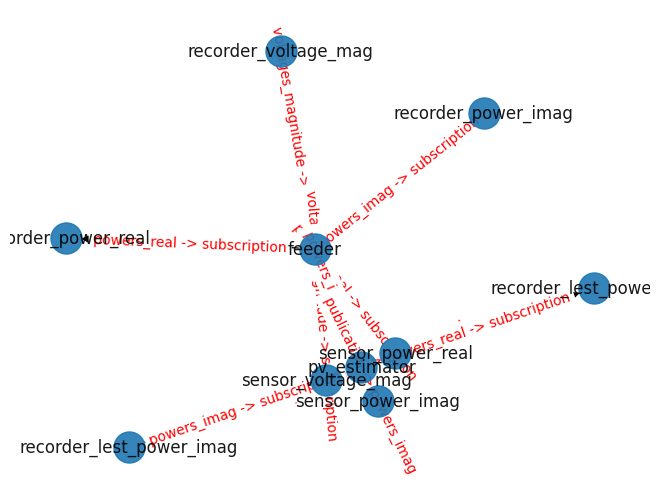

In [2]:
index = 11
SCENARIO = SCENARIOS[index]

path = f"{SCENARIO_DIR}{SCENARIO}"
with open(f"{path}/system.json") as f:
    wiring_diagram = wiring_diagram_utils.WiringDiagram.parse_obj(json.load(f))

wiring_diagram_utils.plot_graph_matplotlib(wiring_diagram)

In [3]:
os.system(f"oedisi build --system {path}/system.json --component-dict {path}/components.json --target-directory build_{SCENARIO}") 

sh: 1: oedisi: not found


32512

In [4]:
os.system("pkill -9 helics_broker")
os.system(f"oedisi run --runner build_{SCENARIO}/system_runner.json")

sh: 1: oedisi: not found


32512

In [5]:
# Directory location
directory = f"{OUTPUTS}/{SCENARIO}"
power_real = os.path.join(directory, "power_real.feather")
power_imag = os.path.join(directory, "power_imag.feather")
power_real_est = os.path.join(directory, "lest_power_real.feather")
power_imag_est = os.path.join(directory, "lest_power_imag.feather")
time = ["12:00"]

from math import sqrt, floor
import pandas as pd
from datetime import datetime
import pyarrow.feather as feather
from matplotlib import colormaps

In [6]:
def get_time(x):
    return datetime.strptime(
        x, '%Y-%m-%d %H:%M:%S'
        ).time().strftime("%H:%M")
    
df_act = pd.read_feather(power_real)
df_act = df_act.drop(columns='time')

df_act = df_act[df_act.lt(0)].dropna(axis=1)

df_act_a = df_act.filter(like='.1')
df_act_b = df_act.filter(like='.2')
df_act_c = df_act.filter(like='.3')

df_est = pd.read_feather(power_real_est)
df_est = df_est.drop(columns='time')
df_est = df_est[df_est.lt(0)].dropna(axis=1)

df_est_a = df_est.filter(like='.1')
df_est_b = df_est.filter(like='.2')
df_est_c = df_est.filter(like='.3')

df_est_a_true = df_est_a.filter(items=df_act_a.columns)
cm = colormaps['tab20'].colors
idx = ['true', 'est']

In [13]:
df_act_a.head()


,P1UDT942-P1UHS0_1247X.1,P1ULV4110.1,P1ULV7633.1,P1ULV4193.1,P1ULV4196.1
0,-10.220309,-34.471283,-37.405318,-33.307667,-1.688294


In [14]:

df_est_a.head()

,P1UDM3856.1,P1UDM3885.1,P1ULV4110.1,P1UDT942.1,P1UDT1433LV.1,P1UDT881.1,P1ULV4196.1,P1UDT943.1,P1UDT1425.1,P1UDT1431-P1UDT895X.1,P1UDT894.1,P1UDT1433.1,P1UDT895LV.1,P1UDT892.1,P1UDT908.1,P1UDM3883.1,P1ULV4193.1,P1UDT892LV.1,P1UDM3888.1,P1UDM3887.1
0,-0.007409,-0.019529,-34.466788,-0.00795,-0.012616,-0.006535,-1.685722,-0.019752,-0.011491,-0.006236,-0.006733,-0.00529,-0.000503,-0.020528,-0.005916,-0.004588,-33.299337,-0.015589,-0.002676,-0.00803


<Axes: >

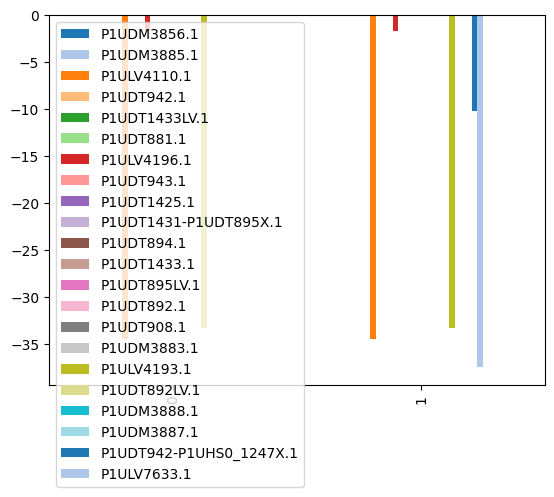

In [22]:
df = pd.concat([df_est_a, df_act_a], ignore_index=True).fillna(0)
fig, ax = plt.subplots()
df.plot.bar(color=cm, ax=ax)

<Axes: >

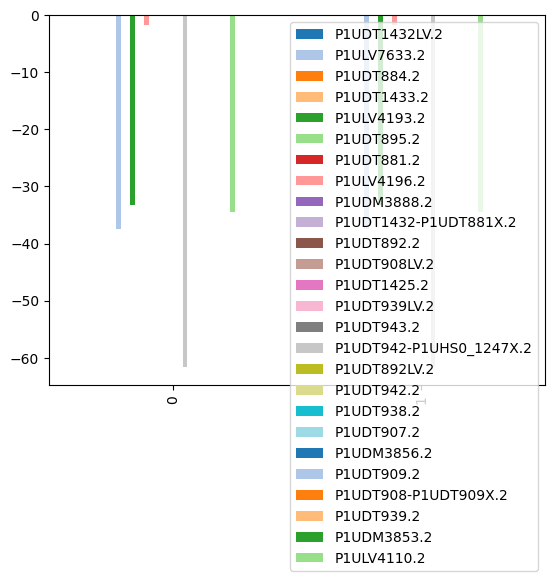

In [23]:
df = pd.concat([df_est_b, df_act_b], ignore_index=True).fillna(0)
fig, ax = plt.subplots()
df.plot.bar(color=cm, ax=ax)


<Axes: >

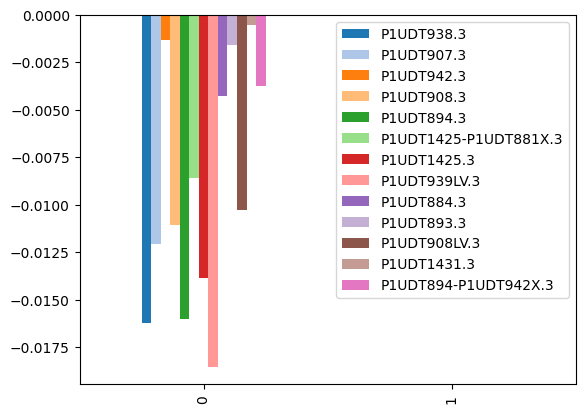

In [24]:
df = pd.concat([df_est_c, df_act_c], ignore_index=True).fillna(0)
fig, ax = plt.subplots()
df.plot.bar(color=cm, ax=ax)